<a href="https://colab.research.google.com/github/HenryNVP/rl-cartpole/blob/main/myCartpole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reinforcement Learninig to Control a Cart-pole System

RL to control the balancing of a cart-pole dynamic system in Gym environment.

## Training the agent

In [ ]:
!pip install gym torch matplotlib

In [ ]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

# Check CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 1. Define the Q-Network
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )

    def forward(self, x):
        return self.fc(x)

# 2. Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        samples = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*samples)
        return (torch.tensor(states, dtype=torch.float32).to(device),
                torch.tensor(actions, dtype=torch.int64).to(device),
                torch.tensor(rewards, dtype=torch.float32).to(device),
                torch.tensor(next_states, dtype=torch.float32).to(device),
                torch.tensor(dones, dtype=torch.float32).to(device))

    def __len__(self):
        return len(self.buffer)

# 3. Epsilon-Greedy Policy
def epsilon_greedy_action(state, q_network, epsilon, action_dim):
    if random.random() < epsilon:
        return random.randint(0, action_dim - 1)
    else:
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        with torch.no_grad():
            return q_network(state).argmax(dim=1).item()


Using device: cuda


In [ ]:
# 4. Train Function
def train_cartpole(env_name, train_with_dynamics=False, episodes=2500, render_interval=100):
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    # Initialize networks, optimizer, and replay buffer
    q_network = QNetwork(state_dim, action_dim).to(device)
    target_network = QNetwork(state_dim, action_dim).to(device)
    target_network.load_state_dict(q_network.state_dict())
    optimizer = optim.Adam(q_network.parameters(), lr=2e-5)
    replay_buffer = ReplayBuffer(20000)

    gamma = 0.99
    epsilon_start = 1.0
    epsilon_end = 0.01
    epsilon_decay = 1000
    batch_size = 256
    target_update = 5
    rewards = []  # Make sure rewards is a Python list here

    for episode in range(episodes):
        state = env.reset()
        episode_reward = 0.0  # Ensure this is a scalar
        done = False

        while not done:
            action = epsilon_greedy_action(state, q_network, epsilon_start, action_dim)
            next_state, reward, done, _ = env.step(action)

            replay_buffer.push(state, action, reward, next_state, done)
            state = next_state
            episode_reward += reward  # Keep episode_reward as scalar

            # Train the Q-network
            if len(replay_buffer) >= batch_size:
                states, actions, rewards_tensor, next_states, dones = replay_buffer.sample(batch_size)
                q_values = q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)
                next_q_values = target_network(next_states).max(dim=1)[0]
                targets = rewards_tensor + gamma * next_q_values * (1 - dones)

                loss = nn.MSELoss()(q_values, targets)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # Update target network
        if episode % target_update == 0:
            target_network.load_state_dict(q_network.state_dict())

        # Decay epsilon
        epsilon_start = max(epsilon_end, epsilon_start - (1 / epsilon_decay))

        # Append the scalar episode reward to the list of rewards
        rewards.append(float(episode_reward))

    env.close()
    return q_network, rewards  # Return both the trained network and the rewards

# 5. Train the agent with and without dynamics
q_network, rewards = train_cartpole("CartPole-v1")


/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
<ipython-input-2-6b510e24584a>:40: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarra

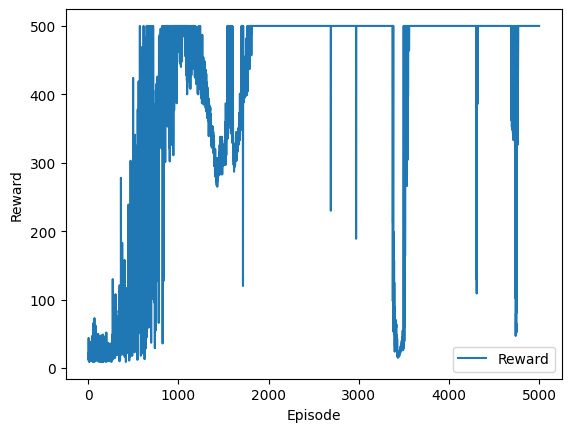

In [ ]:
# 6. Plot rewards
plt.plot(rewards, label="Reward")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.show()

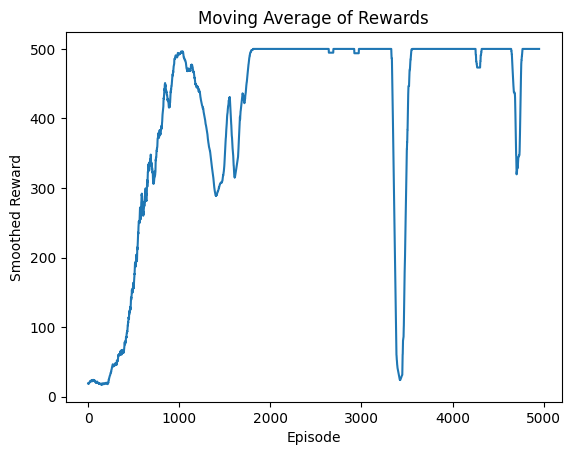

In [ ]:
def plot_moving_average(rewards, window=10):
    smoothed_rewards = np.convolve(rewards, np.ones(window)/window, mode='valid')
    plt.plot(smoothed_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Smoothed Reward')
    plt.title('Moving Average of Rewards')
    plt.show()

plot_moving_average(rewards, window=50)


## Visualization

In [ ]:
#
# install dependencies needed for recording videos
!apt-get install -y xvfb x11-utils
!pip install pyvirtualdisplay==0.2.*

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 libxtst6 libxxf86dga1 x11-xkb-utils xfonts-base
  xfonts-encodings xfonts-utils xserver-common
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 libxtst6 libxxf86dga1 x11-utils x11-xkb-utils xfonts-base
  xfonts-encodings xfonts-utils xserver-common xvfb
0 upgraded, 12 newly installed, 0 to remove and 49 not upgraded.
Need to get 8,046 kB of archives.
After this operation, 12.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfontenc1 amd64 1:1.1.4-1build3 [14.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxfont2 amd64 1:2.0.5-1build1 [94.5 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxkbfile1 amd64 1:1.1.0-1build3 [71.8 kB]
Get:4 http://archive.ubuntu.

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=False, size=(1400, 900))
_ = display.start()

In [ ]:
from gym.wrappers import RecordVideo

# After training, render the agent's performance using the trained policy
def render_trained_agent(env_name, trained_q_network, episodes=10):
    env = gym.make(env_name)

    # Wrap the environment to record videos
    video_directory = "/content/trained_videos"
    env = RecordVideo(env, video_directory, episode_trigger=lambda e: e % 1 == 0)  # Record every episode

    # Render trained agent's performance
    for episode in range(episodes):
        state = env.reset()
        done = False
        while not done:
            action = epsilon_greedy_action(state, trained_q_network, 0.0, env.action_space.n)  # No epsilon for testing
            next_state, reward, done, _ = env.step(action)
            state = next_state
            # env.render() is not needed, because the video is recorded automatically

    env.close()

# After training is completed, render the agent's performance
render_trained_agent("CartPole-v1", q_network)

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment CartPole-v1 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.11/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is dep

In [ ]:
from base64 import b64encode
def render_mp4(videopath: str) -> str:
  """
  Gets a string containing a b4-encoded version of the MP4 video
  at the specified path.
  """
  mp4 = open(videopath, 'rb').read()
  base64_encoded_mp4 = b64encode(mp4).decode()
  return f'<video width=400 controls><source src="data:video/mp4;' \
         f'base64,{base64_encoded_mp4}" type="video/mp4"></video>'

In [ ]:

from IPython.display import HTML
html = render_mp4("/content/trained_videos/rl-video-episode-9.mp4")
HTML(html)
